Import necessary modules

In [1]:
from gpplus.models import GP_Plus
from gpplus.test_functions.analytical import borehole_mixed_variables
from gpplus.preprocessing import train_test_split_normalizeX
from gpplus.utils import set_seed

/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch
torch.__version__

/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.1'

Data generation and prepration:
The next step is to generate the data, standardize it and separate it to train-test sets. This time, we convert the first and sixth features of Borehole example to categorical variables to have a mixed-input example.


Then, we generate 1000 samples, standardize it and use 1% of theem as the training data.

In [2]:
set_seed(4)
qual_ind_lev = {0: 5, 5: 5}
U, y = borehole_mixed_variables(n=10000, qual_ind_val=qual_ind_lev, random_state=4)
Utrain, Utest, ytrain, ytest = train_test_split_normalizeX(U, y, test_size=0.99, qual_index_val=qual_ind_lev)

In [196]:
y.shape

(10000,)

In [23]:
train_x = Utrain
qual_index = list(qual_ind_lev.keys())
all_index = set(range(train_x.shape[-1]))
quant_index = list(all_index.difference(qual_index))
num_levels_per_var = list(qual_ind_lev.values())

In [24]:
lv_columns = []
if True:
#------------------- lm columns --------------------------
        lm_columns = list(set(qual_index).difference(lv_columns))
        if len(lm_columns) > 0:
            qual_kernel_columns = [*lv_columns, lm_columns]
        else:
            qual_kernel_columns = lv_columns

In [31]:
qual_kernel_columns

[[0, 5]]

In [25]:
from gpplus.preprocessing import setlevels
import torch
if True:
#########################
        if len(qual_index) > 0:
            train_x, labels= setlevels(train_x, qual_index=qual_index,return_label = True)
            train_x = torch.tensor(train_x)

In [26]:
train_y = ytrain
multiple_noise = False
if True:
        train_y=train_y.reshape(-1)#.to(**self.tkwargs)
        if multiple_noise:
            noise_indices = list(range(0,num_levels_per_var[-1]))
        else:
            noise_indices = []


In [27]:
lv_dim = 2
from gpplus import kernels
if len(qual_index) > 0:
            ####################### Defined multiple kernels for seperate variables ###################
            qual_kernels = []
            for i in range(len(qual_kernel_columns)):
                qual_kernels.append(kernels.RBFKernel(
                    active_dims=torch.arange(lv_dim) + lv_dim * i) )
                qual_kernels[i].initialize(**{'lengthscale':1.0})
                qual_kernels[i].raw_lengthscale.requires_grad_(False)

In [32]:
quant_correlation_class_name = 'Rough_RBF'
quant_correlation_class = 'RBFKernel'
from gpytorch.constraints import Positive
from gpplus.priors import MollifiedUniformPrior
from gpytorch.priors import NormalPrior
if len(quant_index) == 0:
            correlation_kernel = qual_kernels[0]
            for i in range(1, len(qual_kernels)):
                correlation_kernel *= qual_kernels[i]
else:
            try:
                quant_correlation_class = getattr(kernels,quant_correlation_class)
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % quant_correlation_class
                )
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns) * lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                )
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            
            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))             
                )
            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)  
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))       
                )
                #####################
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel.register_prior(
                    'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
                
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel.register_prior(
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            if len(qual_index) > 0:
                temp = qual_kernels[0]
                for i in range(1, len(qual_kernels)):
                    temp *= qual_kernels[i]
                correlation_kernel = temp*quant_kernel #+ qual_kernel + quant_kernel
            else:
                correlation_kernel = quant_kernel

In [37]:
qual_kernels

[RBFKernel(
   (raw_lengthscale_constraint): Positive()
 )]

In [36]:
quant_kernel

RBFKernel(
  (raw_lengthscale_constraint): Positive()
  (lengthscale_prior): NormalPrior()
)

In [35]:
correlation_kernel

ProductKernel(
  (kernels): ModuleList(
    (0): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (1): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (lengthscale_prior): NormalPrior()
    )
  )
)

In [43]:
noise:float=1e-4
fix_noise:bool=False
lb_noise:float=1e-8

In [45]:
def zeta_matrix(num_levels:int,
        lv_dim:int,
        batch_shape=torch.Size()
    ) -> None:

        if any([i == 1 for i in num_levels]):
            raise ValueError('Categorical variable has only one level!')

        if lv_dim == 1:
            raise RuntimeWarning('1D latent variables are difficult to optimize!')
        
        for level in num_levels:
            if lv_dim > level - 0:
                lv_dim = min(lv_dim, level-1)
                raise RuntimeWarning(
                    'The LV dimension can atmost be num_levels-1. '
                    'Setting it to %s in place of %s' %(level-1,lv_dim)
                )
    
        from itertools import product
        levels = []
        for l in num_levels:
            levels.append(torch.arange(l))

        perm = list(product(*levels))
        perm = torch.tensor(perm, dtype=torch.int64)

        #-------------Mapping-------------------------
        perm_dic = {}
        for i, row in enumerate(perm):
            temp = str(row.tolist())
            if temp not in perm_dic.keys():
                perm_dic[temp] = i

        #-------------One_hot_encoding------------------
        for ii in range(perm.shape[-1]):
            if perm[...,ii].min() != 0:
                perm[...,ii] -= perm[...,ii].min()
            
        perm_one_hot = []
        for i in range(perm.size()[1]):
            perm_one_hot.append( torch.nn.functional.one_hot(perm[:,i]) )

        perm_one_hot = torch.concat(perm_one_hot, axis=1)

        return perm_one_hot, perm, perm_dic

In [84]:
from torch import nn

class Linear_MAP(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        
    def forward(self, input, transform = lambda x: x):
        return F.linear(input,transform(self.weight), self.bias)

In [87]:
import gpytorch
class FFNN(nn.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(FFNN, self).__init__()
        self.hidden_num = len(layers)
        if self.hidden_num > 0:
            self.fci = nn.Linear(input_size, layers[0], bias=False) 
            GP_Plus.register_parameter(str(name)+'fci', self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_fci', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fci')

            for i in range(1,self.hidden_num):
                setattr(self, 'h' + str(i), nn.Linear(layers[i-1], layers[i], bias=False))
                GP_Plus.register_parameter(str(name)+'h'+str(i), getattr(self, 'h' + str(i)).weight )
                GP_Plus.register_prior(name = 'latent_prior'+str(i), prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'h'+str(i))
            
            self.fce = nn.Linear(layers[-1], num_classes, bias= False)
            GP_Plus.register_parameter(str(name)+'fce', self.fce.weight)
            GP_Plus.register_prior(name = 'latent_prior_fce', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fce')
        else:
            self.fci = Linear_MAP(input_size, num_classes, bias = False)
            GP_Plus.register_parameter(name, self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_'+name, prior=gpytorch.priors.NormalPrior(0,1) , param_or_closure=name)

    def forward(self, x, transform = lambda x: x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        """
        if self.hidden_num > 0:
            x = torch.tanh(self.fci(x))
            for i in range(1,self.hidden_num):
                #x = F.relu(self.h(x))
                x = torch.tanh( getattr(self, 'h' + str(i))(x) )
            
            x = self.fce(x)
        else:
            #self.fci.weight.data = torch.sinh(self.fci.weight.data)
            x = self.fci(x, transform)
        return x

In [88]:
# latent variable mapping
uniform_encoding_columns = 2
encoding_type = 'one-hot'
manifold_type='deterministic'
NN_layers = []

self_perm =[]
self_zeta = []
self_random_zeta=[]
self_perm_dict = []
self_A_matrix = []

model = GP_Plus(Utrain, ytrain, qual_ind_lev=qual_ind_lev)
if len(qual_kernel_columns) > 0:
            for i in range(len(qual_kernel_columns)):
                if type(qual_kernel_columns[i]) == int:
                    num = num_levels_per_var[qual_index.index(qual_kernel_columns[i])]
                    cat = [num]
                else:
                    cat = [num_levels_per_var[qual_index.index(k)] for k in qual_kernel_columns[i]]
                    num = sum(cat)

                zeta, perm, perm_dict = zeta_matrix(num_levels=cat, lv_dim = lv_dim)
                self_zeta.append(zeta)
                self_perm.append(perm)
                self_perm_dict.append(perm_dict)       
                ###################################  latent map (manifold) #################################
                model_temp = FFNN(model,input_size= num, num_classes=lv_dim, 
                        layers = NN_layers, name ='latent'+ str(qual_kernel_columns[i])).to('cpu')
                self_A_matrix.append(model_temp)

In [91]:
base='single_constant'
base_hf='zero'
num_sources=int(torch.max(train_x[:,-1])) #???
size=train_x.shape[1]
size

8

In [92]:
Numper_of_pass=1
x = train_x
Sigma_sum=torch.zeros(x.size(0),x.size(0), dtype=torch.float64).to('cpu')
mean_x_sum=torch.zeros(x.size(0), dtype=torch.float64).to('cpu')

In [70]:
def transform_categorical(x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if training == False:
            x = torch.tensor(setlevels(x))
        if encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return zeta[index,:]  

In [116]:
mean_module = model.mean_module
mean_module

ConstantMean(
  (mean_prior): NormalPrior()
)

In [110]:
def single_mean(x):
        base_type=base
        supported_functions = ['sin', 'cos', 'exp', 'log', 'tan', 'asin', 'acos', 'atan', 
                               'sinh', 'cosh', 'tanh', 'asinh', 'acosh', 'atanh', 'sqrt', 
                               'abs', 'ceil', 'floor', 'round']
        
        if base_type in supported_functions:
            # Dynamically call the PyTorch function based on base_type
            transformed_x = getattr(torch, base_type)(x.clone()).float()
        elif base_type.startswith('polynomial-d'):
            degree = int(base_type.split('d')[-1])
            transformed_x = x.clone().double()
            polynomial_terms = [transformed_x.pow(n).float() for n in range(1, degree + 1)]
            transformed_x = torch.cat(polynomial_terms, dim=1)
        else:
            # Default case
            transformed_x = x.float().clone()
        mean_x = mean_module(transformed_x)
        return mean_x

In [77]:
from gpplus.utils.transforms import softplus,inv_softplus
covar_module = kernels.ScaleKernel(
            base_kernel = correlation_kernel,
            outputscale_constraint=Positive(transform=softplus,inv_transform=inv_softplus),
        )

In [111]:
import torch.nn.functional as F
training = True
for NP in range(Numper_of_pass):
            x_forward_raw=x.clone()
            nd_flag = 0
            if x.dim() > 2:
                xsize = x.shape
                x = x.reshape(-1, x.shape[-1])
                nd_flag = 1
            
            x_new= x
            if len(qual_kernel_columns) > 0:
                embeddings = []
                for i in range(len(qual_kernel_columns)):
                    temp= transform_categorical(x=x[:,qual_kernel_columns[i]].clone().type(torch.int64).to('cpu'), 
                        perm_dict = self_perm_dict[i], zeta = self_zeta[i])
                dimm=x_forward_raw.size()[0]
                
                embeddings.append(self_A_matrix[i](temp.float().to('cpu')))
                x_new= torch.cat([embeddings[0],x[...,quant_index].to('cpu')],dim=-1)
                
            if nd_flag == 1:
                x_new = x_new.reshape(*xsize[:-1], -1)
        #################### Multiple baises (General Case) ####################################  
            
            mean_x = single_mean(x_new).to('cpu') 

            covar_x = covar_module(x_new).to('cpu')
            mean_x_sum+=mean_x
            Sigma_sum += covar_x.evaluate()+ torch.outer(mean_x, mean_x)

In [119]:
if True:
# End of the loop for forward pasess ----> Compute ensemble mean and covariance
        k = Numper_of_pass
        ensemble_mean = mean_x_sum/k
        ensemble_covar = torch.zeros_like(Sigma_sum) 
        ensemble_covar= Sigma_sum/k
        ensemble_covar -= torch.outer(ensemble_mean, ensemble_mean)
        ensemble_covar=gpytorch.lazy.NonLazyTensor(ensemble_covar)
        Sigma_sum=0

Create and fit the GP+ model: Firstly, we create the model using GP_Plus command, and then the model is optimized with model.fit

In [65]:
model = GP_Plus(Utrain, ytrain, qual_ind_lev=qual_ind_lev)
model.fit(bounds=True)

## Learning the model's parameters has started ##


/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


## Learning the model's parameters is successfully finished ##


/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


In [185]:
model.training

True

In [183]:
i = 0
A = model.A_matrix
zeta = model.zeta[i]
positions = A[i](x=zeta.float().to('cpu'))
#positions.shape
level = torch.max(model.perm[i]+1, axis = 0)[0].tolist()
levels = level
perm = model.perm[i]
constraints_flag=False

In [173]:
#x_cate_zeta is the prior embedding for all categorical observations
#x_cate_latent are the latent variable values
i = 0
x_cate_zeta= transform_categorical(x=x[:,qual_kernel_columns[i]].clone().type(torch.int64).to('cpu'), 
                        perm_dict = self_perm_dict[i], zeta = self_zeta[i])
x_cate_latent = model.A_matrix[i](x_cate_zeta.float().to('cpu'))
print(x_cate_zeta.shape)
print(x_cate_latent.shape)

torch.Size([100, 10])
torch.Size([100, 2])


In [180]:
x_cate_latent.unique().sort()

torch.return_types.sort(
values=tensor([-2.6171e-01, -2.1992e-01, -1.9734e-01, -1.8409e-01, -1.8275e-01,
        -1.6436e-01, -1.5461e-01, -1.5303e-01, -8.1902e-02, -6.7315e-02,
        -5.5410e-02, -4.8922e-02, -4.1810e-02, -3.9174e-02, -3.7587e-02,
        -1.3620e-02, -1.9610e-05,  2.2210e-02,  2.4985e-02,  3.5810e-02,
         3.7321e-02,  4.8047e-02,  5.3546e-02,  6.6776e-02,  6.8133e-02,
         8.6527e-02,  8.9838e-02,  9.6275e-02,  9.7861e-02,  1.0261e-01,
         1.2567e-01,  1.5986e-01,  1.7444e-01,  1.9284e-01,  2.0258e-01,
         2.0417e-01,  2.4362e-01,  2.5722e-01,  2.7274e-01,  2.8069e-01,
         2.9528e-01,  3.1367e-01,  3.2342e-01,  3.4708e-01,  4.7904e-01,
         4.9264e-01,  5.5943e-01,  5.8249e-01], grad_fn=<SortBackward0>),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))

In [184]:
positions.unique().sort()

torch.return_types.sort(
values=tensor([-2.6171e-01, -2.1992e-01, -1.9734e-01, -1.8409e-01, -1.8275e-01,
        -1.6436e-01, -1.5461e-01, -1.5303e-01, -8.1902e-02, -6.7315e-02,
        -5.5410e-02, -4.8922e-02, -4.1810e-02, -3.9174e-02, -3.7587e-02,
        -1.3620e-02, -1.9610e-05,  2.2210e-02,  2.4985e-02,  3.5810e-02,
         3.7321e-02,  4.8047e-02,  5.3546e-02,  6.6776e-02,  6.8133e-02,
         8.6527e-02,  8.9838e-02,  9.6275e-02,  9.7861e-02,  1.0261e-01,
         1.2567e-01,  1.5986e-01,  1.7444e-01,  1.9284e-01,  2.0258e-01,
         2.0417e-01,  2.4362e-01,  2.5722e-01,  2.7274e-01,  2.8069e-01,
         2.9528e-01,  3.1367e-01,  3.2342e-01,  3.2401e-01,  3.2500e-01,
         3.4708e-01,  4.7904e-01,  4.9264e-01,  5.5943e-01,  5.8249e-01],
       grad_fn=<SortBackward0>),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_4050/3697863923.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', 20)  # Get a colormap from matplotlib, 'tab20' has nice distinct colors


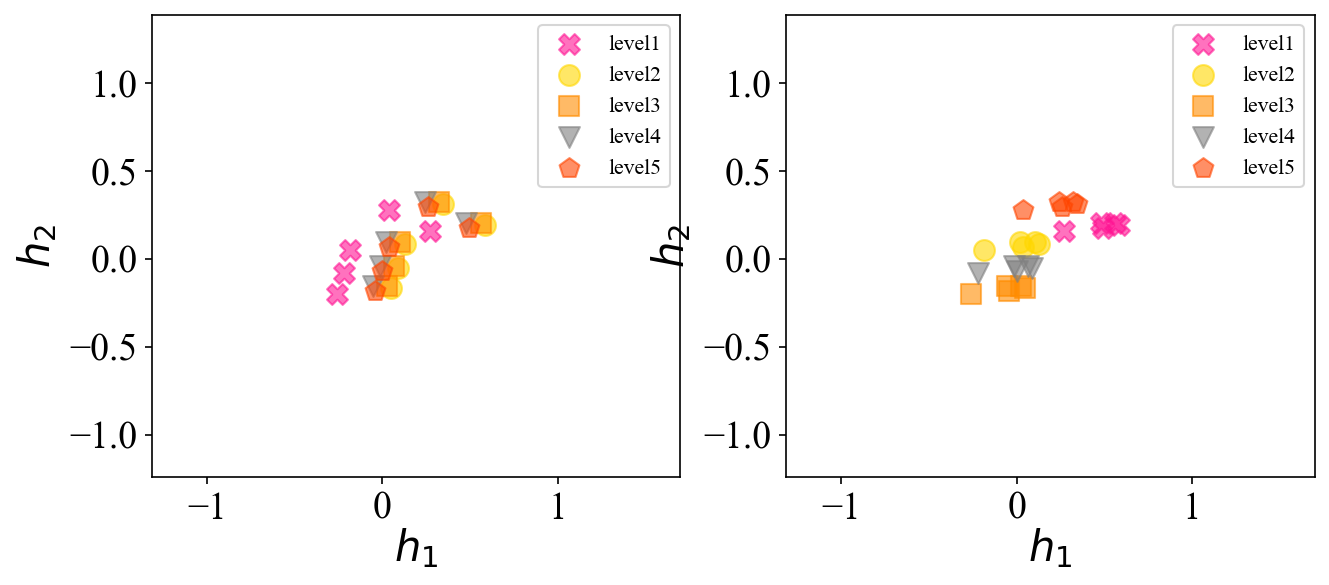

In [165]:
type = 'cat'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
colors_base = ['deeppink', 'gold', 'darkorange', 'gray', 'orangered', 'blue']
cmap = cm.get_cmap('tab20', 20)  # Get a colormap from matplotlib, 'tab20' has nice distinct colors
colors = colors_base  + [cmap(i) for i in range(len(colors_base), 20)]
marker = ['X','o','s',"v", 'p', 'v', '^', '<', '>','*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_','1', '2', '3', '4',]
positions = positions.cpu().detach().numpy()

if len(levels) > 1:
        fig,axs = plt.subplots(1, len(levels),figsize=(10,4))
        for j in range(len(levels)):
            for i in range(levels[j]):
                index = torch.where(perm[:,j] == i) 
                if i<=10:
                    fontsize=5
                    s_size=100
                else:
                    fontsize=5
                    s_size=100
                if  type=='mf':
                    axs[j].scatter(positions[index][...,0], positions[index][...,1], label = legend[i], color = colors[i], marker=marker[i],s=s_size,alpha=.6)#marker=r'$\clubsuit$'
                    plt.xlabel(r'$z_1$',labelpad=0,rotation=0,fontsize=20)
                    plt.ylabel(r'$z_2$',labelpad=10,rotation=0, fontsize=20)
                
                elif type=='cat':
                    axs[j].scatter(positions[index][...,0], positions[index][...,1], label = 'level' + str(i+1), color = colors[i], marker=marker[i],s=s_size,alpha=.6)#marker=r'$\clubsuit$'
                    axs[j].set_xlabel(r'$h_1$', labelpad=0, fontsize=20)
                    axs[j].set_ylabel(r'$h_2$', labelpad=5,fontsize=20)
                else:
                    raise ValueError("type should be either 'mf' or cat:")
                # plt.tight_layout()
                # axs[j].legend()
                axs[j].legend(loc='upper right', fontsize='xx-small')

                tempxi = np.min(positions[...,0])-0.2 * (np.abs(np.min(positions[...,0])) +5)
                tempxx = np.max(positions[...,0]) + 0.2 * (np.abs(np.max(positions[...,0])) +5)
                tempyi = np.min(positions[...,1])-0.2 * (np.abs(np.min(positions[...,1])) +5)
                tempyx = np.max(positions[...,1]) + 0.2 * (np.abs(np.max(positions[...,1])) +5)
                axs[j].set_xlim(tempxi, tempxx)
                axs[j].set_ylim(tempyi, tempyx)

Visualization and evaluation: As this is a mixed-space problem, we use the 'model.visualize_latent()' command to visualize the learnt latent space of the categorical features.

Then, the accuarcy of the model is evaluated using 'model.evaluation(); command

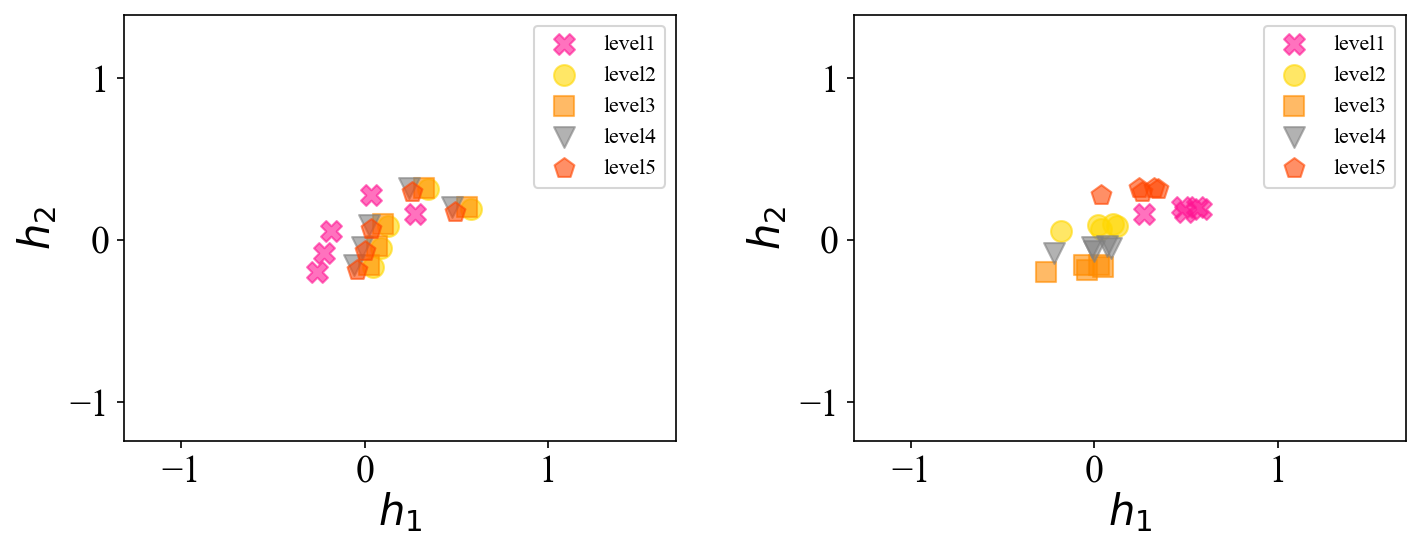

In [144]:
model.visualize_latent()
#model.evaluation(Utest, ytest)

In [43]:
with torch.no_grad():
            trained_pred_dist = model.likelihood(Utest)
            trained_pred_dist

In [187]:
ypred = model.predict(Utest)

################MSE######################
MSE = 3200.91526
#########################################
################Noise####################
The estimated noise parameter (varaince) is tensor([2.7715])
The estimated noise std is tensor([1.6648])
#########################################


tensor([ 90.7364,  53.5765,  74.2432,  ...,  73.1191, 107.3619,  51.5002],
       dtype=torch.float64)

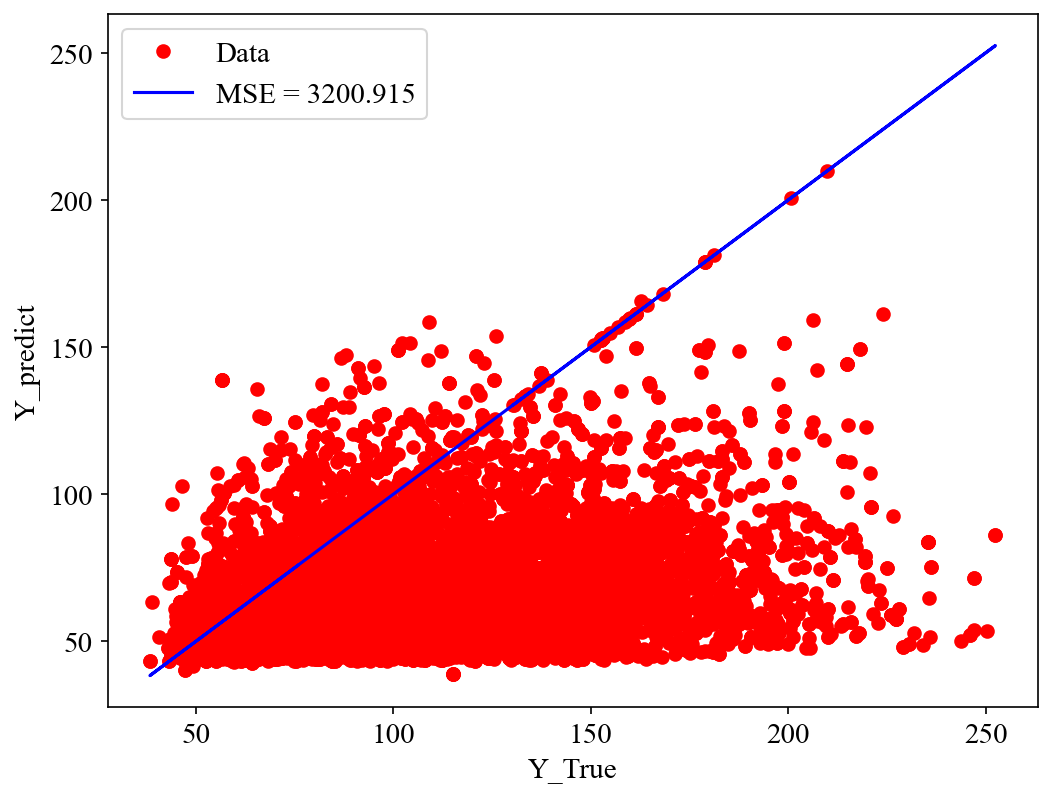

In [192]:
model.score(Utest,ytest)

In [195]:
model.evaluation(Utest,ytest)

╒═════════════════════════════════════════╤═══════════╕
│ Metric                                  │ Value     │
╞═════════════════════════════════════════╪═══════════╡
│ Negative Log-Likelihood (NLL)           │ -0.294041 │
├─────────────────────────────────────────┼───────────┤
│ Mean Squared Error (MSE)                │ 3200.92   │
├─────────────────────────────────────────┼───────────┤
│ Mean Absolute Error  (MAE)              │ 45.3688   │
├─────────────────────────────────────────┼───────────┤
│ Relative Root Mean Square Error (RRMSE) │ 1.53712   │
├─────────────────────────────────────────┼───────────┤
│ Interval Score (IS)                     │ 527.44    │
╘═════════════════════════════════════════╧═══════════╛
